# 7.3 베이스 라인 모델
# 7.3.1 피처 엔지니어링

In [1]:
import pandas as pd
data_path = ""

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [2]:
all_data = pd.concat([train, test]) # 훈련 데이터와 테스트 데이터 합치기
all_data = all_data.drop('target', axis=1) # 타깃값 제거

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
all_data_encoded = encoder.fit_transform(all_data)

In [3]:
num_train = len(train)

X_train = all_data_encoded[:num_train]
X_test = all_data_encoded[num_train:]

y = train['target']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size=0.1, stratify=y, random_state=10)

# 7.3.2 모델 훈련

# 7.4 성능 개선(1)

In [5]:
import pandas as pd
data_path = ''

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
all_data = pd.concat([train, test])
all_data = all_data.drop('target', axis=1) # 타깃값 제거

## 이진 피처 인코딩

In [ ]:
all_data['bin_3'] = all_data['bin_3'].map({'F':0, 'T':1})
all_data['bin_4'] = all_data['bin_4'].map({'N':0, 'Y':1})

## 순서형 피처 인코딩

In [ ]:
ord1dict = {'Novice':0, 'Contributor':1, 'Expert':2, 'Master':3, 'Grandmaster':4}
ord2dict = {'Freezing':0, 'Cold':1, 'Warm':2, 'Hot':3, 'Boiling Hot':4, 'Lava Hot': 5}
all_data['ord_1'] = all_data['ord_1'].replace(ord1dict)
all_data['ord_2'] = all_data['ord_1'].replace(ord2dict)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord_345 = ['ord_3', 'ord_4', 'ord_5']

ord_encoder = OrdinalEncoder() # OrdinalEncoder 객체 생성
# ordinal 인코딩 적용
all_data[ord_345] = ord_encoder.fit_transform(all_data[ord_345])

# 피처별 인코딩 순서 출력
for feature, categories in zip(ord_345, ord_encoder.categories_):
    print(feature)
    print(categories)


## 명목형 피처 인코딩

In [ ]:
# 명목형 피처 인코딩
nom_features = ['nom_' + str(i) for i in range(10)]

from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder() # OneHotEncoder 객체 생성
# 원-핫 인코딩 적용
encoded_nom_matrix = onehot_encoder.fit_transform(all_data[nom_features])
encoded_nom_matrix # 원-핫 인코딩은 회소 행렬을 CSR 형식으로 반환

**희소 행렬과 COO, CSR 형식**  
대부분 값이 0으로 채워진 행렬을 희소 행렬(sparse matrix)이라고 한다. 반대로 대부분 값이 0이 아닌 값으로 채워진 행렬을 밀집 행렬(dense matrix)이라고 한다. 원-핫 인코딩을 적용하면 희소 행렬을 만든다. 희소행렬은 메모리 낭비가 심해지고 행렬 크기도 커져서 연산 시간도 오래 걸리게 된다.  
이런 문제를 개선하기 위해서 행렬 형식을 변환해주는데 대표적으로 COO(coordinate list) 형식과 CSR(compressed sparse row) 형식이 있다. 이 중 CSR이 메모리를 더 적게 쓰면서 연산도 빨라서 주로 사용된다.

In [ ]:
all_data = all_data.drop(nom_features, axis=1) # 기존 명목형 피처 삭제

## 날짜 피처 인코딩

In [ ]:
# 날짜피처 인코딩
date_features = ['day', 'month'] # 날짜 피처

# 원-핫 인코딩 적용
encoded_date_matrix = onehot_encoder.fit_transform(all_data[date_features])
all_data = all_data.drop(date_features, axis=1) # 기존 날짜 피처 삭제

encoded_date_matrix

# 7.4.2 피처 엔지니어링(2) : 피처 스케일링

## 순서형 피처 스케일링

In [ ]:
from sklearn.preprocessing import MinMaxScaler

ord_features = ['ord_' + str(i) for i in range(6)] # 순서형 피처
# min-max 정규화
all_data[ord_features] = MinMaxScaler().fit_transform(all_data[ord_features])

## 인코딩 및 스케일링된 피처 합치기

In [ ]:
from scipy import sparse
# 인코딩 및 스케일링된 피처 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data),
                              encoded_nom_matrix,
                              encoded_date_matrix],
                             format='csr')
all_data_sprs

## 데이터 나누기

In [ ]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data_sprs[:num_train] # 0~num_train - 1 행
X_test = all_data_sprs[num_train:] # num_train ~ 마지막 행

y=train['target']

# 훈련 데이터, 검증 데이터 분리
X_train, X_valid, y_train, y_alid = train_test_split(X_train, y, test_size = 0.1, stratify=y, random_state=10)

# 7.4.3 하이퍼파라미터 최적화

# 7.4.4 모델 성능 검증

# 7.5 성능 개선(2)
훈련 데이터의 전체를 모델 학습에 사용한다.

In [ ]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data_sprs[:num_train] # 0~num_train - 1 행
X_test = all_data_sprs[num_train:] # num_train ~ 마지막 행

y=train['target']

# 훈련 데이터, 검증 데이터 분리
X_train, X_valid, y_train, y_alid = train_test_split(X_train, y, test_size = 0.1, stratify=y, random_state=10)

In [ ]:
X_train.shape, y.shape, X_valid.shape

# 성능 개선 3

In [48]:
!pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.4 MB/s eta 0:00:00 0:00:01
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


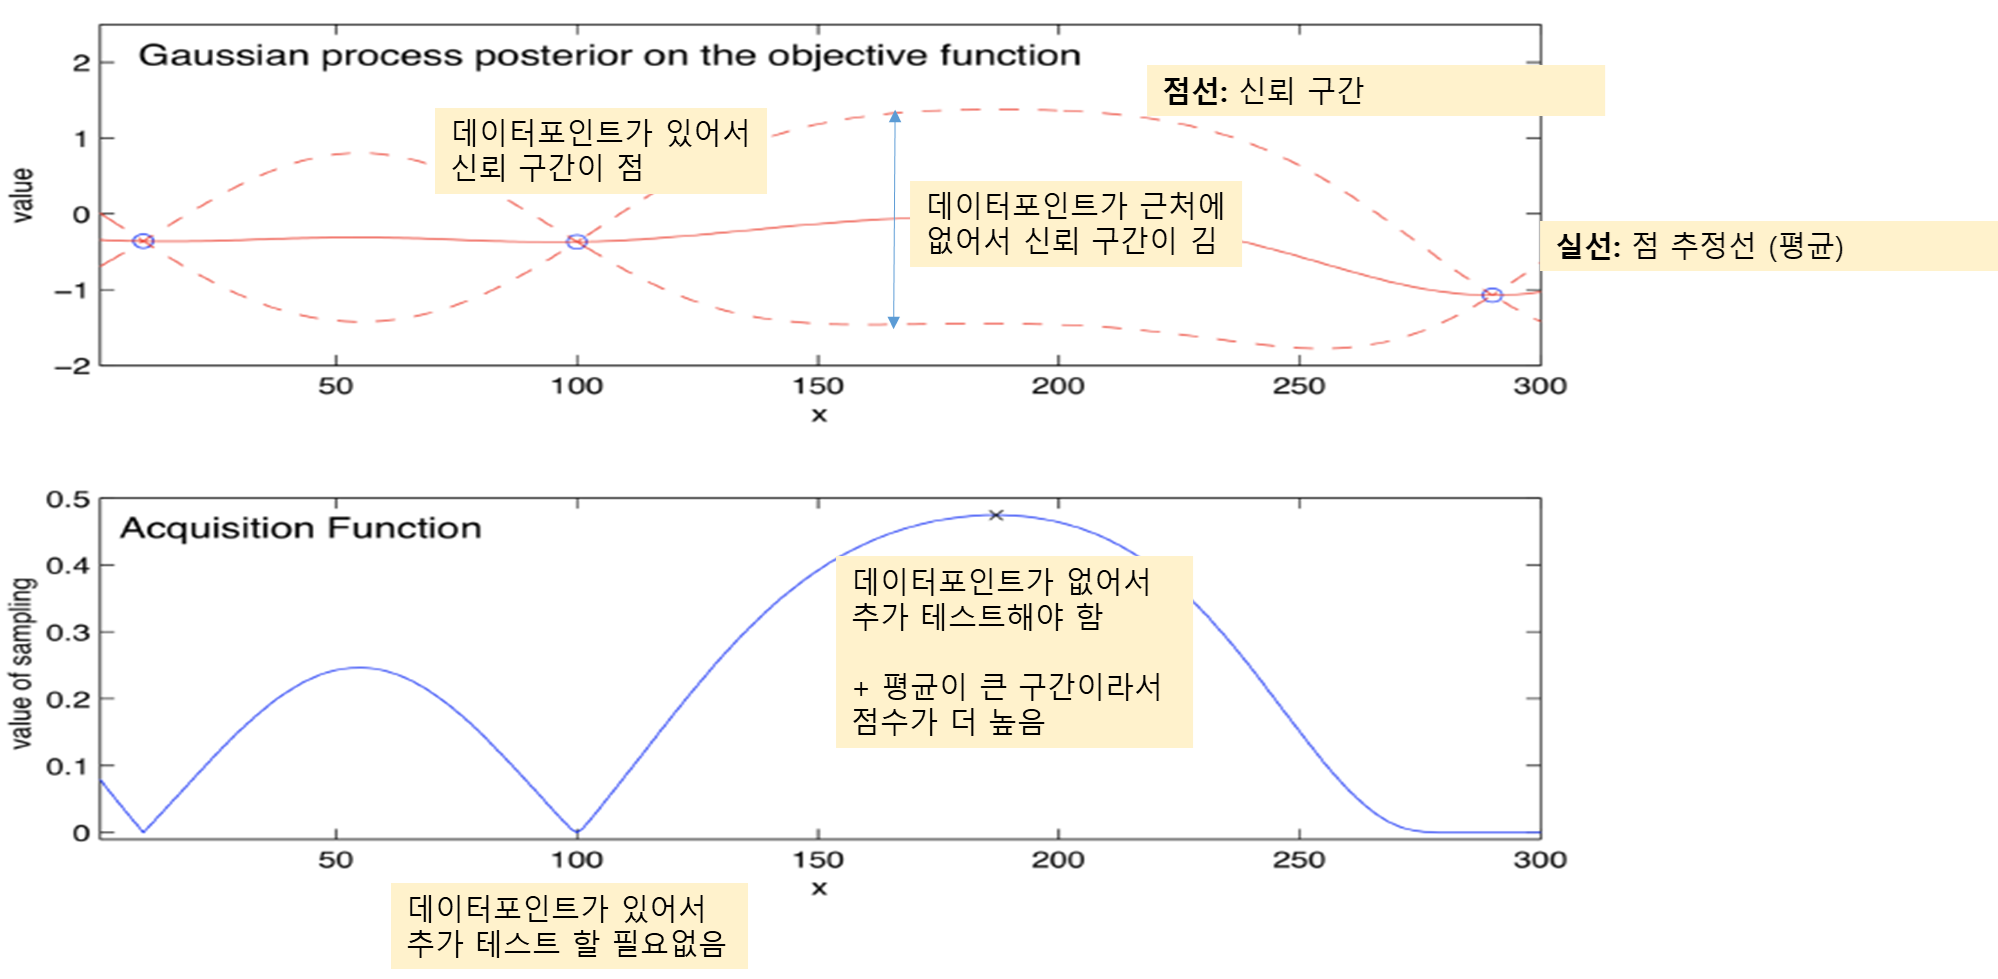

그리드 검색: 미리 정의된 하이퍼파라미터 조합의 그리드를 생성하고 이 그리드에 대해 모든 가능한 조합을 탐색합니다. 이는 미리 지정된 값들만을 고려하므로 탐색 공간이 넓을수록 계산 비용이 증가하고 효율성이 낮아집니다.
베이지안 최적화: 확률적 모델링을 사용하여 하이퍼파라미터 공간을 탐색합니다. 이전에 시도한 하이퍼파라미터 조합의 결과를 기반으로 하이퍼파라미터 공간을 효율적으로 탐색합니다. 따라서 불필요한 조합을 건너뛰고 최적의 조합에 빠르게 수렴할 수 있습니다.


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import pandas as pd
import lightgbm as lgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [47]:
logistic_model = LogisticRegression()

In [52]:
lr_params = {'C': (0.1, 0.5), 'max_iter': (800, 1000)}

# 베이지안 최적화 객체 생성
bayes_logistic_model = BayesSearchCV(estimator=logistic_model,
                                     search_spaces=lr_params,
                                     scoring='roc_auc',
                                     n_iter=5,  # 반복 횟수
                                     random_state=42,
                                    verbose =2)

In [ ]:
bayes_logistic_model.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print('최적 하이퍼파라미터:', bayes_logistic_model.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
# 테스트 데이터에 대한 예측
y_preds = bayes_logistic_model.predict_proba(X_test)[:, 1]

# 제출 파일 생성
submission['target'] = y_preds
submission.to_csv('submission_bayes_logistic.csv', index=False)

# Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier

# 결정 트리 모델 생성
dt_model = DecisionTreeClassifier()

# 하이퍼파라미터 값 목록
dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30]}

# 그리드서치 객체 생성
gridsearch_dt_model = GridSearchCV(estimator=dt_model,
                                   param_grid=dt_params,
                                   scoring='roc_auc',  # 평가지표
                                   cv=5,
                                verbose =2)

# 그리드서치 수행
gridsearch_dt_model.fit(X_train, y_train)

print('최적 하이퍼파라미터:', gridsearch_dt_model.best_params_)

# 타깃값 1일 확률 예측
y_preds = gridsearch_dt_model.best_estimator_.predict_proba(X_test)[:, 1]

# 제출 파일 생성
submission['target'] = y_preds
submission.to_csv('submission_dt.csv')


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .....................criterion=gini, max_depth=None; total time=25.2min
[CV] END .....................criterion=gini, max_depth=None; total time=20.5min
[CV] END .....................criterion=gini, max_depth=None; total time=17.7min
[CV] END .....................criterion=gini, max_depth=None; total time=12.0min
[CV] END .....................criterion=gini, max_depth=None; total time=13.1min
[CV] END .......................criterion=gini, max_depth=10; total time=  44.9s
[CV] END .......................criterion=gini, max_depth=10; total time=  38.8s
[CV] END .......................criterion=gini, max_depth=10; total time=  40.3s
[CV] END .......................criterion=gini, max_depth=10; total time=  39.3s
[CV] END .......................criterion=gini, max_depth=10; total time=  41.6s
[CV] END .......................criterion=gini, max_depth=20; total time= 2.6min
[CV] END .......................criterion=gini, m

# lightgbm

In [ ]:
from lightgbm import LGBMClassifier

# LightGBM 모델 생성
lgb_model = LGBMClassifier()

# 하이퍼파라미터 값 목록
lgb_params = {'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [100, 200, 300]}

# 그리드서치 객체 생성
gridsearch_lgb_model = GridSearchCV(estimator=lgb_model,
                                    param_grid=lgb_params,
                                    scoring='roc_auc',  # 평가지표
                                    cv=5)

# 그리드서치 수행
gridsearch_lgb_model.fit(X_train, y_train)

print('최적 하이퍼파라미터:', gridsearch_lgb_model.best_params_)

# 타깃값 1일 확률 예측
y_preds = gridsearch_lgb_model.best_estimator_.predict_proba(X_test)[:, 1]

# 제출 파일 생성
submission['target'] = y_preds
submission.to_csv('submission_lgb.csv')


[LightGBM] [Info] Number of positive: 66071, number of negative: 149929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 347.925864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19416
[LightGBM] [Info] Number of data points in the train set: 216000, number of used features: 9708
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.305884 -> initscore=-0.819432
[LightGBM] [Info] Start training from score -0.819432
[LightGBM] [Info] Number of positive: 66071, number of negative: 149929


# SVM

In [ ]:
from sklearn.svm import SVC

# SVM 모델 생성
svm_model = SVC(probability=True)

# 하이퍼파라미터 값 목록
svm_params = {'C': [1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

# 그리드서치 객체 생성
gridsearch_svm_model = GridSearchCV(estimator=svm_model,
                                    param_grid=svm_params,
                                    scoring='roc_auc',  # 평가지표
                                    cv=5)

# 그리드서치 수행
gridsearch_svm_model.fit(X_train, y_train)

print('최적 하이퍼파라미터:', gridsearch_svm_model.best_params_)

# 타깃값 1일 확률 예측
y_preds = gridsearch_svm_model.best_estimator_.predict_proba(X_test)[:, 1]

# 제출 파일 생성
submission['target'] = y_preds
submission.to_csv('submission_svm.csv')


In [ ]:
# def model_evaluation(train_data, test_data, train_target, models_dict, valid_data=None, valid_target=None):
#     results = []
#     submissions = {}

#     for model_name, model_data in models_dict.items():
#         print(f"Training {model_name}...")
        
#         model = model_data["model"]
#         params = model_data["params"]
        
#         gridsearch_model = GridSearchCV(estimator=model,
#                                         param_grid=params,
#                                         scoring='roc_auc',
#                                         verbose=2)  # verbose=2로 설정하여 상세 정보 출력
        
#         gridsearch_model.fit(train_data, train_target)
        
#         print(f"Best parameters for {model_name}: {gridsearch_model.best_params_}")
        
#         if valid_data is not None and valid_target is not None:
#             y_valid_preds = gridsearch_model.best_estimator_.predict_proba(valid_data)[:,1]
#             f1 = f1_score(valid_target, gridsearch_model.best_estimator_.predict(valid_data))
#             roc_auc = roc_auc_score(valid_target, y_valid_preds)
#             results.append({"Model": model_name, "ROC AUC": roc_auc, "F1 Score": f1})
        
#         y_preds = gridsearch_model.best_estimator_.predict_proba(test_data)[:,1]
#         submissions[model_name] = y_preds
    
#     if valid_data is not None and valid_target is not None:
#         print(pd.DataFrame(results))
    
#     for model_name, y_preds in submissions.items():
#         submission = pd.DataFrame()
#         submission['target'] = y_preds
#         submission.to_csv(f'{model_name}_submission.csv', index=False)

In [ ]:
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size=0.1, stratify=y, random_state=10)
# #
# # 모델 딕셔너리
# models = {
#     "Logistic Regression": {"model": LogisticRegression(), "params": {'C':[0.1], 'max_iter':[800], 'solver':['liblinear'], 'random_state':[42]}},
#     "Support Vector Machine": {"model": SVC(probability=True), "params": {'C': [10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}},
#     "Decision Tree": {"model": DecisionTreeClassifier(), "params": {'criterion': ['gini', 'entropy'], 'max_depth': [10]}},
#     "XGBoost": {"model": XGBClassifier(eval_metric='logloss'), "params": {'learning_rate': [0.1], 'n_estimators': [100]}},
#     "LightGBM": {"model": LGBMClassifier(), "params": {'learning_rate': [0.05], 'n_estimators': [100]}}
# }

# model_evaluation(X_train, X_test, y_train, models, X_valid, y_valid)

Training Logistic Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END C=0.1, max_iter=800, random_state=42, solver=liblinear; total time=  37.8s
[CV] END C=0.1, max_iter=800, random_state=42, solver=liblinear; total time=  44.2s
[CV] END C=0.1, max_iter=800, random_state=42, solver=liblinear; total time=  41.2s
[CV] END C=0.1, max_iter=800, random_state=42, solver=liblinear; total time=  38.4s
[CV] END C=0.1, max_iter=800, random_state=42, solver=liblinear; total time=  39.8s
Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 800, 'random_state': 42, 'solver': 'liblinear'}
Training Support Vector Machine...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
